In [31]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import joblib
RANDOM_STATE = 1

In [32]:
DATA_PATH = "Crop_recommendation.csv"
df = pd.read_csv(DATA_PATH)
print(df.shape)
display(df.head())
df.info()
df.describe().T

(2200, 10)


,Nitrogen,phosphorus,potassium,temperature,humidity,ph,rainfall,label,Unnamed: 8,Unnamed: 9
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice,NaN,NaN
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice,NaN,NaN
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice,NaN,NaN
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice,NaN,NaN
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Nitrogen     2200 non-null   int64  
 1   phosphorus   2200 non-null   int64  
 2   potassium    2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
 8   Unnamed: 8   0 non-null      float64
 9   Unnamed: 9   0 non-null      float64
dtypes: float64(6), int64(3), object(1)
memory usage: 172.0+ KB


,count,mean,std,min,25%,50%,75%,max
Nitrogen,2200.0,50.551818,36.917334,0.000000,21.000000,37.000000,84.250000,140.000000
phosphorus,2200.0,53.362727,32.985883,5.000000,28.000000,51.000000,68.000000,145.000000
potassium,2200.0,48.149091,50.647931,5.000000,20.000000,32.000000,49.000000,205.000000
temperature,2200.0,25.616244,5.063749,8.825675,22.769375,25.598693,28.561654,43.675493
humidity,2200.0,71.481779,22.263812,14.258040,60.261953,80.473146,89.948771,99.981876
ph,2200.0,6.469480,0.773938,3.504752,5.971693,6.425045,6.923643,9.935091
rainfall,2200.0,103.463655,54.958389,20.211267,64.551686,94.867624,124.267508,298.560117
Unnamed: 8,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Unnamed: 9,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
df['Unnamed: 8'].value_counts()

Series([], Name: count, dtype: int64)

In [35]:
df.drop(columns=['Unnamed: 8', 'Unnamed: 9'],inplace=True)

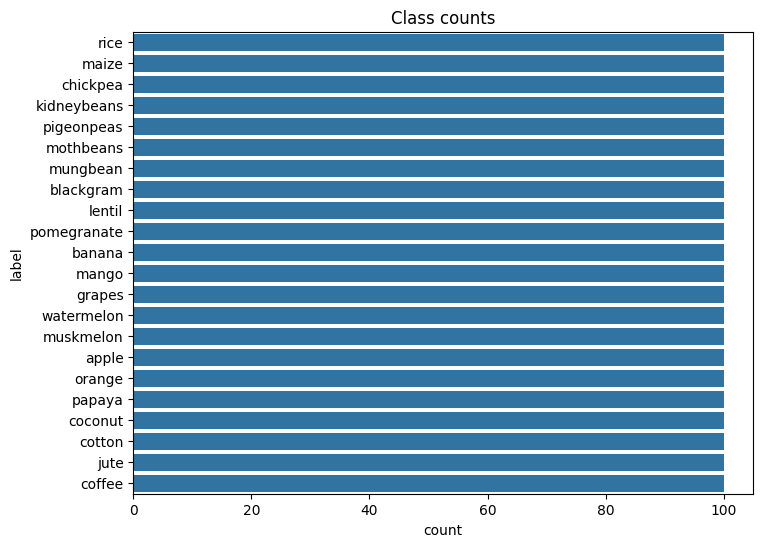

In [36]:
plt.figure(figsize=(8,6))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title("Class counts")
plt.show()

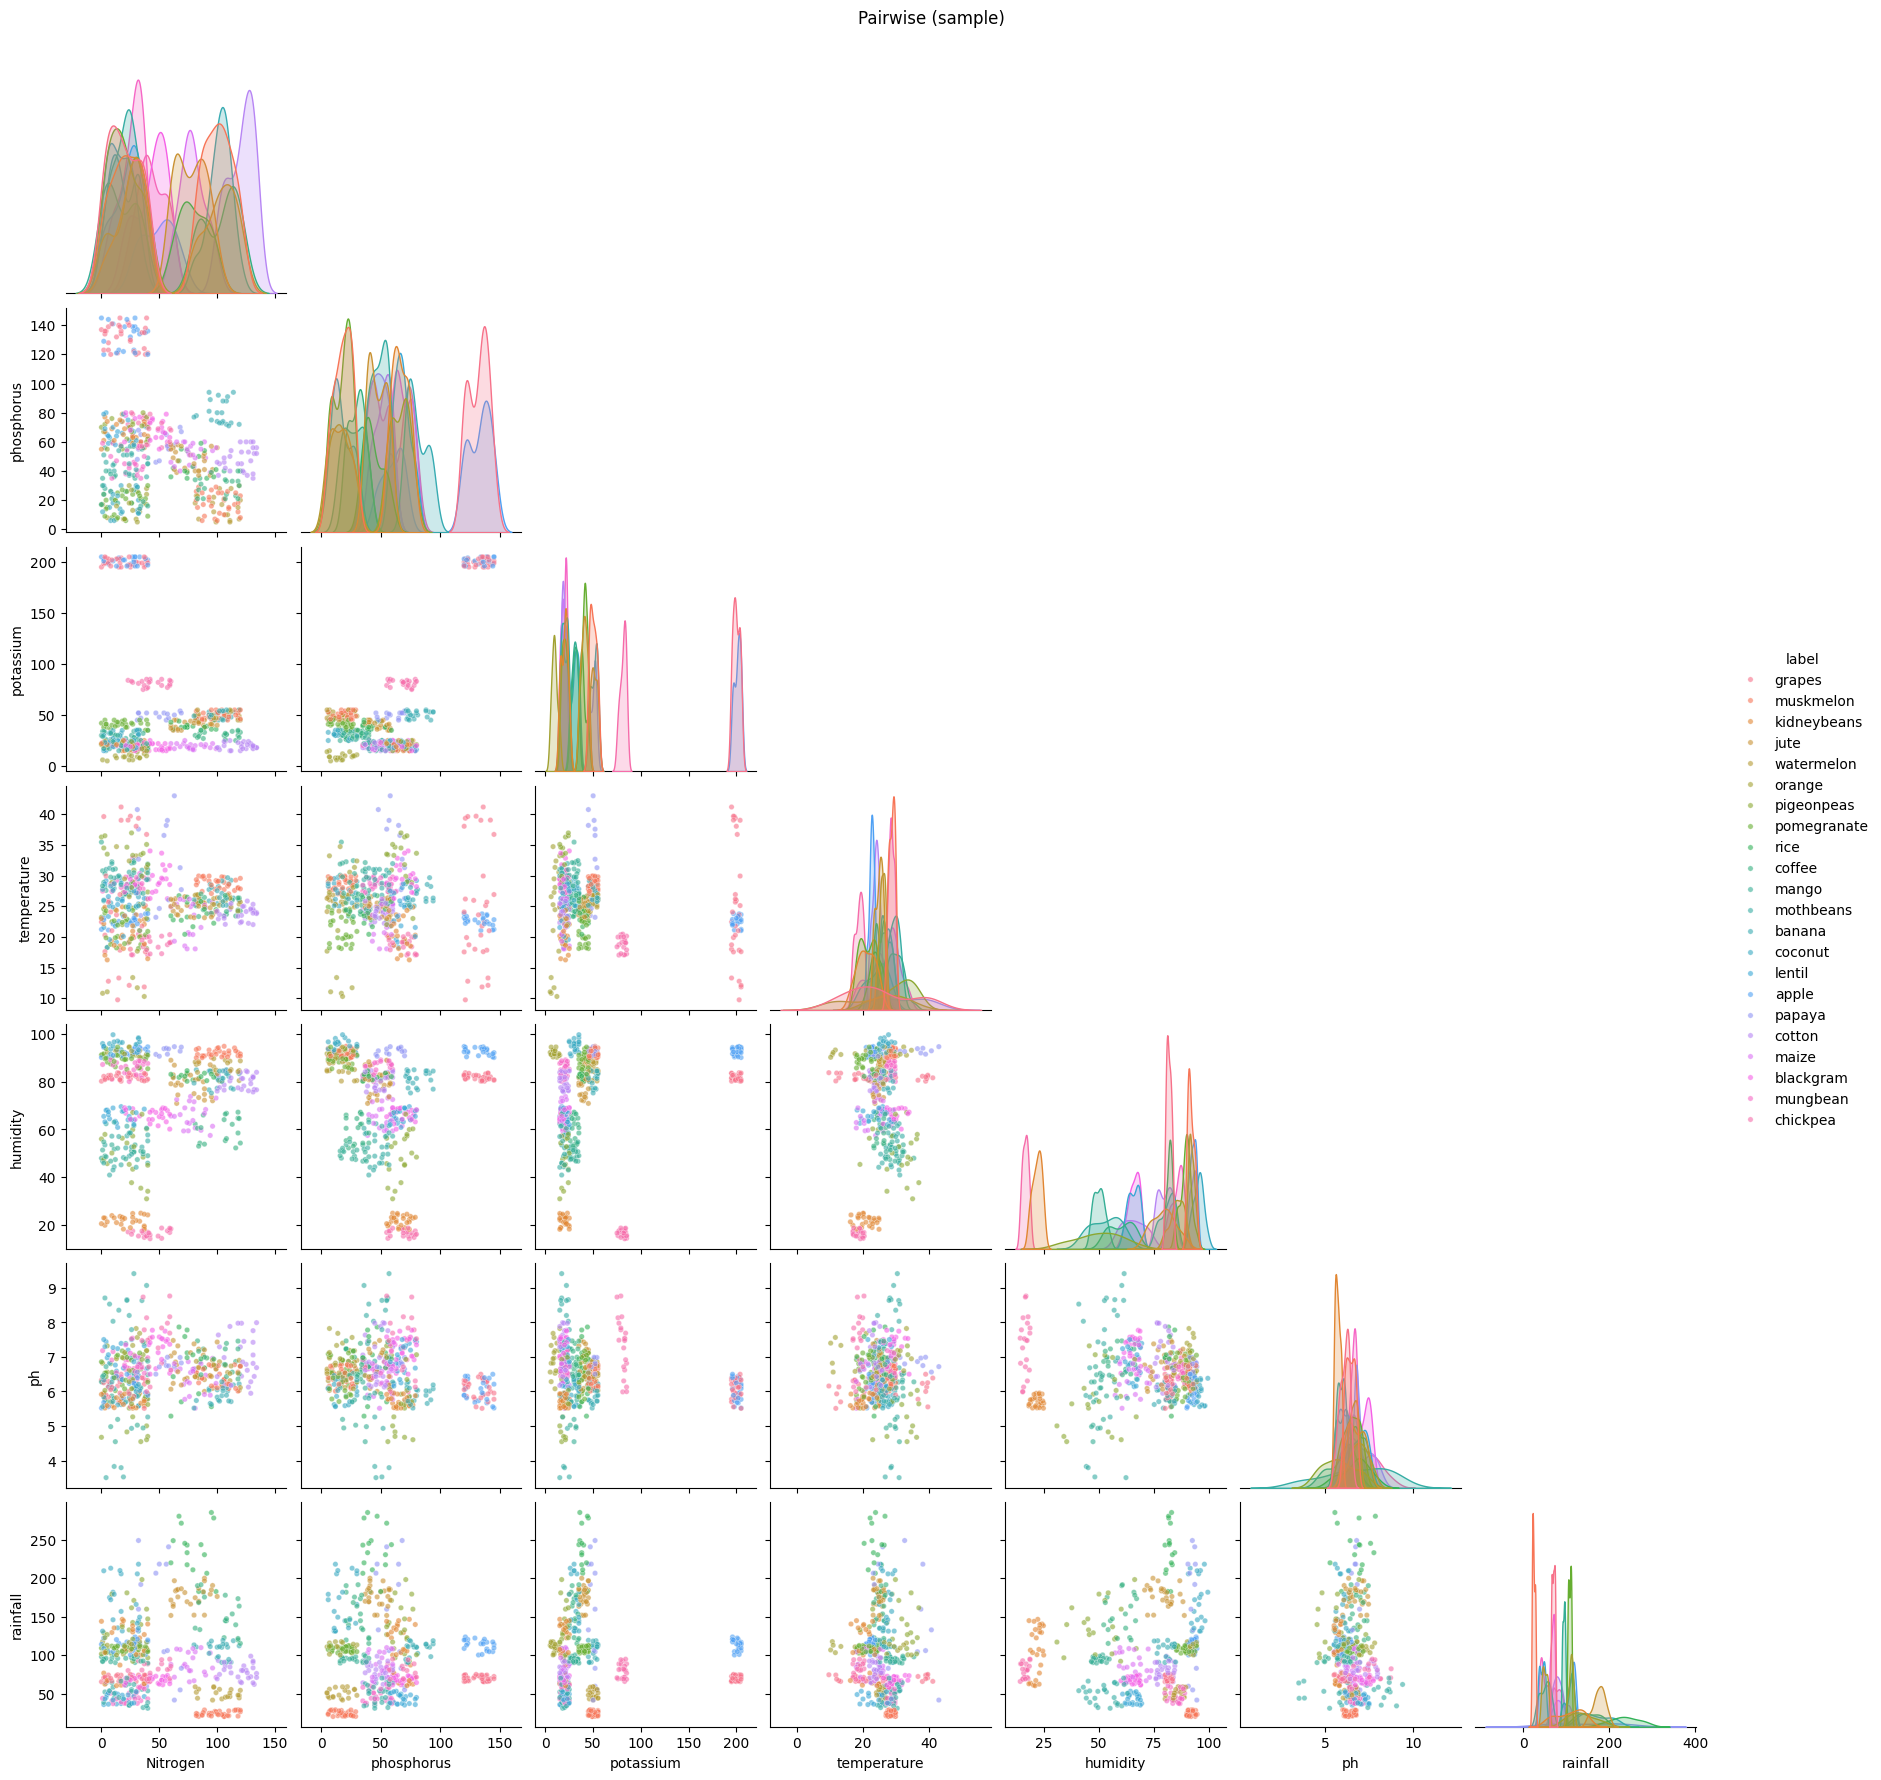

In [37]:
sample = df.sample(n=500, random_state=RANDOM_STATE)
sns.pairplot(sample, vars=['Nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall'], hue='label', corner=True, plot_kws={'s':15,'alpha':0.6})
plt.suptitle("Pairwise (sample)", y=1.02)
plt.show()

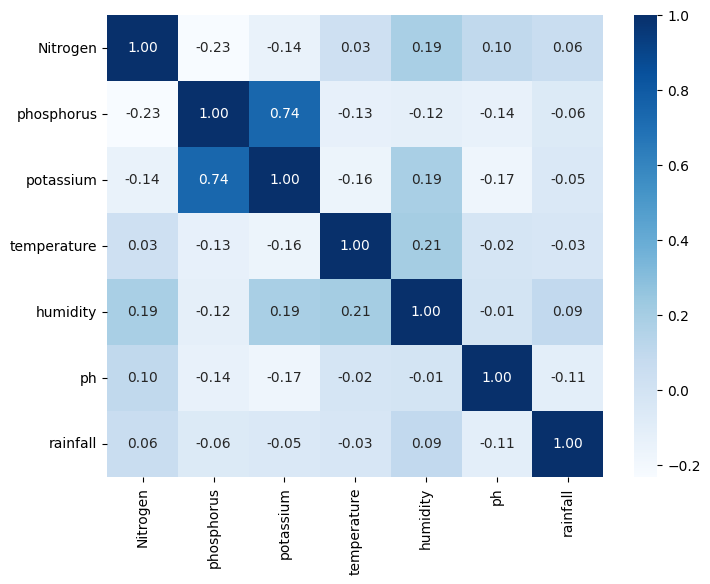

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['Nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall']].corr(), annot=True, fmt='.2f', cmap='Blues')
plt.show()

In [39]:
df['N_ratio'] = df['Nitrogen'] / (df['Nitrogen']+df['phosphorus']+df['potassium'] + 1e-9)
df['P_ratio'] = df['phosphorus'] / (df['Nitrogen']+df['phosphorus']+df['potassium'] + 1e-9)
df['K_ratio'] = df['potassium'] / (df['Nitrogen']+df['phosphorus']+df['potassium'] + 1e-9)
df['N_x_rain'] = df['Nitrogen'] * df['rainfall']

feature_cols = ['Nitrogen','phosphorus','potassium','temperature','humidity','ph','rainfall','N_ratio','P_ratio','K_ratio','N_x_rain']
X = df[feature_cols].copy()
y = df['label'].copy()

le = LabelEncoder()
y_enc = le.fit_transform(y)
display(pd.Series(y_enc).value_counts())


20    100
11    100
3     100
9     100
18    100
13    100
14    100
2     100
10    100
19    100
1     100
12    100
7     100
21    100
15    100
0     100
16    100
17    100
4     100
6     100
8     100
5     100
Name: count, dtype: int64

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y_enc, test_size=0.2, stratify=y_enc,random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(1760, 11) (440, 11)


In [41]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
hist_gb = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

print("Random Forest CV:", cross_val_score(rf, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1).mean())
print("HistGradientBoost CV:", cross_val_score(hist_gb, X_train, y_train, cv=skf, scoring='accuracy', n_jobs=-1).mean())


Random Forest CV: 0.9926136363636363
HistGradientBoost CV: 0.984659090909091


In [42]:
pipe = Pipeline([('scaler', StandardScaler()), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1))])

param_dist = {
    'clf__n_estimators': [100,200,400,800],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2,5,10],
    'clf__min_samples_leaf': [1,2,4],
    'clf__max_features': ['sqrt', 0.6, 0.8]
}

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(pipe, param_dist, n_iter=20, cv=skf, scoring='accuracy', n_jobs=-1, random_state=RANDOM_STATE, verbose=2)
%time rs.fit(X_train, y_train)
print("Best score:", rs.best_score_)
print("Best params:", rs.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: total: 2.39 s
Wall time: 1min 24s
Best score: 0.9931818181818182
Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 1, 'clf__max_features': 'sqrt', 'clf__max_depth': None}


In [43]:
# refining with GridSearchCV
best = rs.best_params_
grid = {
    'clf__n_estimators': [best['clf__n_estimators'], best['clf__n_estimators']*2],
    'clf__max_depth': [best['clf__max_depth'], None],
    'clf__min_samples_leaf': [best['clf__min_samples_leaf']],
}
gs = GridSearchCV(pipe, grid, cv=skf, scoring='accuracy', n_jobs=-1, verbose=2)
%time gs.fit(X_train, y_train)
print(gs.best_score_, gs.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: total: 3.48 s
Wall time: 6.02 s
0.9926136363636363 {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 200}


In [44]:
best_model = gs.best_estimator_ if 'gs' in globals() else rs.best_estimator_
y_pred = best_model.predict(X_test)
print("Test acc:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=le.classes_))

Test acc: 0.9954545454545455
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       0.95      1.00      0.98        20
      grapes       1.00      1.00      1.00        20
        jute       1.00      1.00      1.00        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       1.00      0.95      0.97        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      0.95      0.97        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20
      orange       1.00      1.00      1.00        2

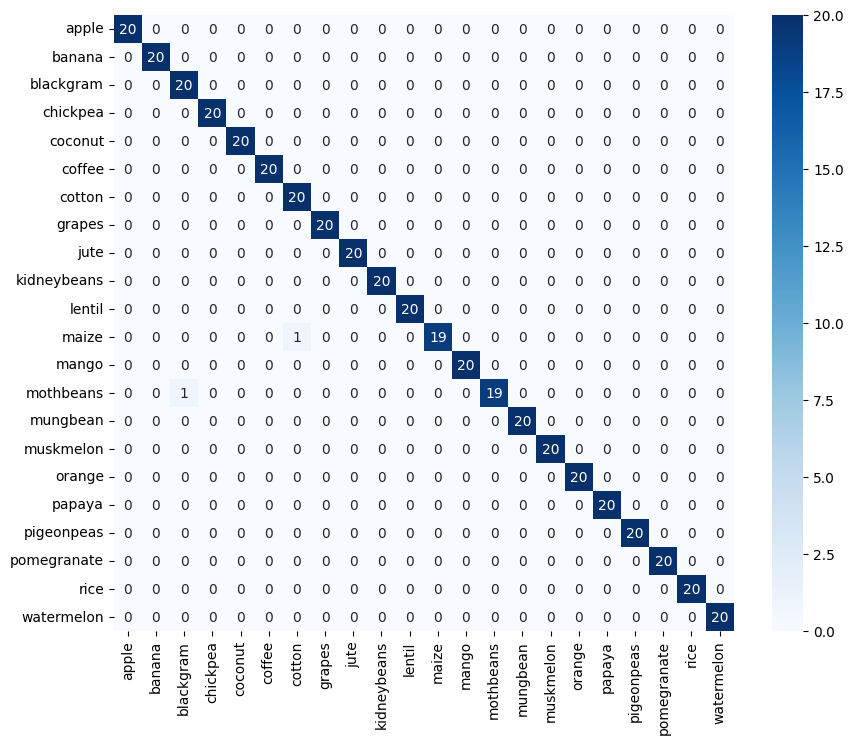

In [45]:
# Confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_ ,cmap='Blues')
plt.show()

rainfall       0.191402
humidity       0.188843
potassium      0.131354
phosphorus     0.120710
K_ratio        0.067087
Nitrogen       0.065464
N_x_rain       0.062966
temperature    0.049696
N_ratio        0.047099
P_ratio        0.041332
ph             0.034048
dtype: float64

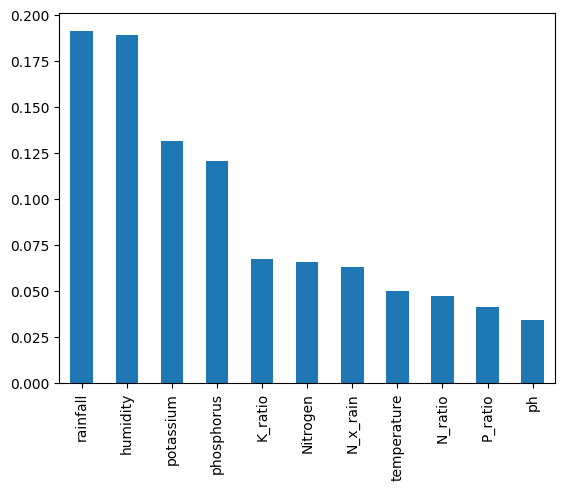

In [46]:
# Feature importances
clf = best_model.named_steps['clf']
if hasattr(clf, 'feature_importances_'):
    fi = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
    display(fi)
    fi.plot(kind='bar'); plt.show()

In [47]:
#saving model
joblib.dump(best_model, "crop_recommender_model.joblib")
joblib.dump(le, "label_encoder.joblib")

['label_encoder.joblib']